<a href="https://colab.research.google.com/github/krithikaceg/waste_management/blob/master/waste_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing library**

In [2]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

Using TensorFlow backend.


## Data Ingestion

In [5]:
!wget https://raw.githubusercontent.com/krithikaceg/waste_management/master/dataset-resized.zip
zip_images = 'dataset-resized.zip'
import zipfile
zip_ref = zipfile.ZipFile(zip_images, 'r')
zip_ref.extractall("wm-dataset")
zip_ref.close()


--2019-02-22 15:18:09--  https://raw.githubusercontent.com/krithikaceg/waste_management/master/dataset-resized.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43720495 (42M) [application/zip]
Saving to: ‘dataset-resized.zip’

dataset-resized.zip 100%[===================>]  41.69M   220MB/s    in 0.2s    

2019-02-22 15:18:10 (220 MB/s) - ‘dataset-resized.zip’ saved [43720495/43720495]



## EDA

In [12]:

path_to_images = 'wm-dataset/dataset-resized/*/*.jpg'
images = glob(path_to_images)
trainingset = []
traininglabels = []
num = len(images)
count = 1
#READING IMAGES AND RESIZING THEM
for i in images:
    print(str(count)+'/'+str(num),end='\r')
    trainingset.append(cv2.resize(cv2.imread(i),(scale,scale)))
    traininglabels.append(i.split('/')[-2])
    count=count+1
trainingset = np.asarray(trainingset)
print(set(traininglabels))
traininglabels = pd.DataFrame(traininglabels)

{'metal', 'paper', 'glass', 'cardboard', 'trash', 'plastic'}


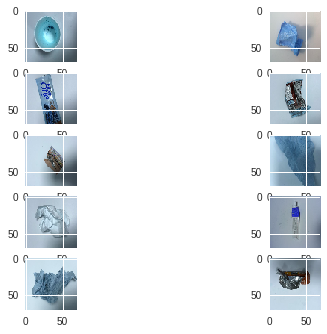

In [13]:
for i in range(10):
    plt.subplot(5, 2, i+1)
    plt.imshow(trainingset[i])

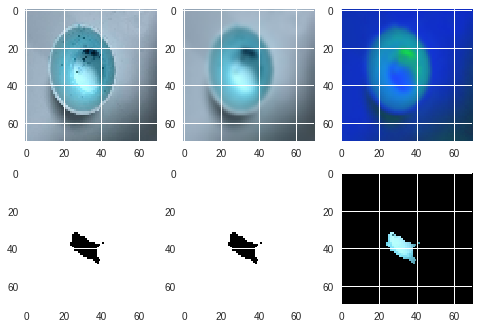

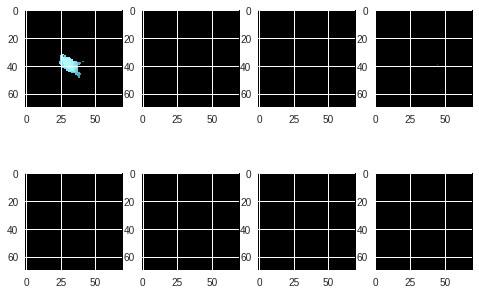

In [14]:
new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes['cardboard' 'glass' 'metal' 'paper' 'plastic' 'trash']
6


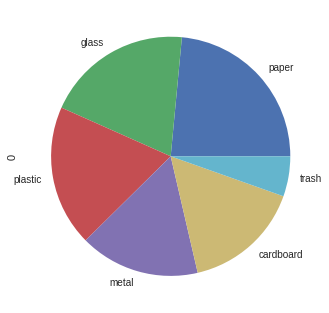

In [16]:
labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

## Model

In [0]:
new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [0]:
generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [19]:
np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)  

In [26]:
print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_test, y_test))  # Evaluate on test set

2274/2274 [==============================] - 90s 39ms/step
[1.7909876215111926, 0.23306948109058928]
253/253 [==============================] - 10s 40ms/step
[1.7913725324299024, 0.2094861667146796]


In [20]:
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[33  4  3  0  0  0]
 [24 12 13  1  0  0]
 [15 11 14  1  0  0]
 [31 13 13  3  0  0]
 [29  7 12  0  0  0]
 [12  0  2  0  0  0]]


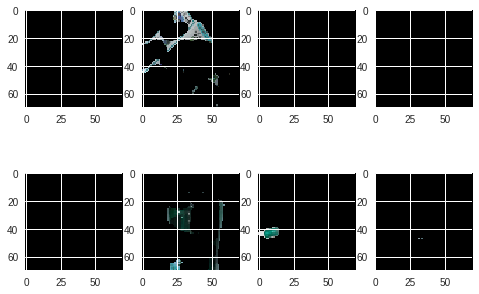

In [31]:
for i in range(8):
  plt.subplot(2,4,i+1)
  plt.imshow(x_test[i])
  
  

In [33]:
for i in range(8):
  print("Predicted: " + labels.classes_[y_class[i]])
  print("Actual class: "+labels.classes_[y_check[i]])

Predicted: cardboard
Actual class: trash
Predicted: glass
Actual class: paper
Predicted: cardboard
Actual class: glass
Predicted: cardboard
Actual class: plastic
Predicted: cardboard
Actual class: paper
Predicted: metal
Actual class: glass
Predicted: glass
Actual class: glass
Predicted: metal
Actual class: metal


## Conclusion
Even though it has classified, the result is not satisfactory. 

Couple of suggestions:

1. We are not sure if the training data is sufficient or trains the model well. May be 2500 images is not enough or doesn't provide variety for our model to distinguish.
- Train with more number of number of variety of images.

2. Test the images with Amazon ML or Google Vision.

3. We are adding only three layers here. We can add more layers for better training and classification.

4. May be Neural networks is not good at classifying these images. Try different technologies.


**Next Steps:**
1. Collect more images and train our model. 

2. Use the established/proven tools to classify our images to check if the input data is sufficient.

3. Leverage deep learning technologies better.

4. Try different technologies until the classification is 
